<div style="background-color:teal; color:white; padding:10px; font-size:20px">
Installs

In [2]:
!conda update -n base -c defaults conda -y

Retrieving notices: ...working... done
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.7.4

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.7.4



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - conda


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    autovizwidget-0.20.0       |  py310h06a4308_0          27 KB
    ca-certificates-2023.08.22 |       h06a4308_0         123 KB
    certifi-2023.7.22          |  py310h06a4308_0         153 KB
    colorama-0.4.6             |  py310h06a4308_0          31 KB
    conda-content-trust-0.2.0  |  py310h

In [3]:
!conda install pytorch torchvision -c pytorch -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.7.4

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.7.4



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - pytorch
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ffmpeg-4.3                 |       hf484d3e_0         9.9 MB  pytorch
    gnutls-3.6.15              |       he1e5248_0         1.0 MB
    lame-3.100                 |       h7b6447c_0         323 KB
    libiconv-1.16              |       h7f8727e_2         736 KB
    libtasn1-4.19.0            |       h5eee18b_0          63 KB
    nettle-3.7.3               |       hbbd107a_1         809 KB
    openh264-2.1.1          

In [4]:
# !pip install torchvision

In [5]:
!pip install boto3

In [6]:
import os
import json
import boto3
import sagemaker
import torch
import torchvision
from sagemaker.pytorch import PyTorchModel
from sagemaker import get_execution_role, Session

sess = Session()
role = get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


<div style="background-color:teal; color:white; padding:10px; font-size:20px">
Inference Script

- `model_fn` - Loads weights of model

- `input_fn` - Deserialize and pre-process incoming data

- `predict_fn` - Feeds transformed data to model

- `output_fn` - Handles output post-processing

In [7]:
%%writefile ./script/inference.py

from PIL import Image
import io
import json
import logging
import sys
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

#=======================================================================
#                        MODEL DEFINITION
#=======================================================================

class CIFAR10Net(nn.Module):
    def __init__(self):
        super(CIFAR10Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Linear(256, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 10)
        
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))
        
        x = self.adaptive_pool(x)
        x = x.view(-1, 256)
        
        x = F.leaky_relu(self.bn5(self.fc1(x)))
        x = self.dropout(x)
        
        x = F.leaky_relu(self.bn6(self.fc2(x)))
        x = self.dropout(x)
        
        x = self.fc3(x)
        return x
    
#=======================================================================
#                       PREPARE MODEL
#=======================================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model weights
def model_fn(model_dir):
    # nn.DataParallel() wrapping is because the model training weights were saved w/ 'module.' prefix
    model = CIFAR10Net()
    with open(os.path.join(model_dir, "model.pth"), "rb") as f:
        model.load_state_dict(torch.load(f))
    model.to(device).eval()
    return model

#=======================================================================
#                      INFERENCE FUNCTIONS
#=======================================================================

# Deserialize & pre-process input data
def input_fn(request_body, request_content_type):
    if request_content_type == "application/x-image":
        img_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])
        image = Image.open(io.BytesIO(request_body))
        return img_transforms(image).unsqueeze(0)
    raise ValueError("Unsupported content type: {}".format(request_content_type))

# Perform prediction
def predict_fn(input_data, model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_data = input_data.to(device)
    with torch.no_grad():
        output = model(input_data)
        probabilities = F.softmax(output, dim=1)
    return probabilities

# Post-process the prediction
def output_fn(predictions, content_type):
    # assert content_type == 'application/json'
    res = predictions.cpu().numpy().tolist()
    return json.dumps(res)

Overwriting ./script/inference.py


In [8]:
artifacts_s3_path = "s3://pytorch-aws-train-deploy-project/training/pytorch-training-2023-09-12-20-24-06-264/output/model.tar.gz"

model = PyTorchModel(
    entry_point="inference.py",# model & deployment definition
    source_dir="script",
    role=role,
    model_data= artifacts_s3_path, # model weights
    framework_version="1.5.0",
    py_version="py3",
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


<div style="background-color:teal; color:white; padding:10px; font-size:20px">
Deployment Overview

In [ ]:
<img src="./images/deployment_overview.png" width="500" />

<div style="background-color:teal; color:white; padding:10px; font-size:20px">
Undeployed Inference Testing

Below is a SageMaker utility script provided for simulating a deployment environment for inference script testing.

In [9]:
import sys
# import importlib

sys.path.append('script')

# importlib.reload(inference)
from inference import input_fn, model_fn, output_fn, predict_fn

In [10]:
from IPython.display import Image
import shutil
import tarfile
import botocore

In [11]:
def fetch_model(model_data):
    """Untar the model.tar.gz object either from local file system
    or a S3 location

    Args:
        model_data (str): either a path to local file system starts with
        file:/// that points to the `model.tar.gz` file or an S3 link
        starts with s3:// that points to the `model.tar.gz` file

    Returns:
        model_dir (str): the directory that contains the uncompress model
        checkpoint files
    """

    model_dir = "/tmp/model"
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    if model_data.startswith("file"):
        _check_model(model_data)
        shutil.copy2(
            os.path.join(model_dir, "model.tar.gz"), os.path.join(model_dir, "model.tar.gz")
        )
    elif model_data.startswith("s3"):
        # get bucket name and object key
        bucket_name = model_data.split("/")[2]
        key = "/".join(model_data.split("/")[3:])

        s3 = boto3.resource("s3")
        try:
            s3.Bucket(bucket_name).download_file(key, os.path.join(model_dir, "model.tar.gz"))
        except botocore.exceptions.ClientError as e:
            if e.response["Error"]["Code"] == "404":
                print("the object does not exist.")
            else:
                raise

    # untar the model
    tar = tarfile.open(os.path.join(model_dir, "model.tar.gz"))
    tar.extractall(model_dir)
    tar.close()

    return model_dir

def test(model_data):
    # decompress the model.tar.gz file
    model_dir = fetch_model(model_data)

    # load the model
    model = model_fn(model_dir)

    # simulate some input data to test transform_fn
    img_path = '/root/Experiments_tut/toy_pytorch_project/data/cifar10_foldered/train/airplane/10008.png'
    # Open image in binary mode
    with open(img_path, "rb") as f:
        payload = f.read()

    content_type = "application/x-image"
    input_object = input_fn(payload, content_type)
    predictions = predict_fn(input_object, model)
    res = output_fn(predictions, content_type)
    print(res)
    return

What we should see below will be the raw outputs of the model (no softmax or argmax). 

In [12]:
test(artifacts_s3_path)

[[0.995245635509491, 2.5102170297941484e-07, 0.003998189233243465, 0.00013806301285512745, 0.00017953809583559632, 5.2023820899194106e-05, 7.705754978815094e-05, 1.0771899496830883e-06, 0.0003022710734512657, 5.908238563279156e-06]]


<div style="background-color:teal; color:white; padding:10px; font-size:20px">
Deploy

In [13]:
predictor = model.deploy(
    initial_instance_count=1,
    instance_type="ml.c4.xlarge")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
------!

In [14]:
class ImageSerializer(sagemaker.serializers.BaseSerializer):
    CONTENT_TYPE = 'application/x-image'

    def serialize(self, data):
        return data

# Assign the custom serializer to the predictor
predictor.serializer = ImageSerializer()

<div style="background-color:teal; color:white; padding:10px; font-size:20px">
Deployed Inference Testing

Lets test this with the model actually deployed. We will quickly verify the .png image and then submit it to the model. Note that the logits get returned as a JSON object.

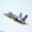

In [17]:
from IPython.display import Image

img_path = '/root/Experiments_tut/toy_pytorch_project/data/cifar10_foldered/train/airplane/10008.png'

# Display the image
Image(filename=img_path)

In [20]:
# Open image in binary mode
with open(img_path, "rb") as f:
    payload = f.read()

# To accept JSON object as response
predictor.accept = 'application/json'

# Pass to deployed inference model -> Get prediction
response = predictor.predict(payload)
print(response)

[[9.95245755e-01 2.51022698e-07 3.99818597e-03 1.38063420e-04
  1.79538620e-04 5.20239264e-05 7.70577826e-05 1.07719211e-06
  3.02273140e-04 5.90826767e-06]]


<div style="background-color:teal; color:white; padding:10px; font-size:20px">
Delete Resources

Finally, delete the endpoint and all other associated resources

In [21]:
predictor.delete_endpoint()